In [44]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 2

#### Test sample

In [45]:
# Sample data (replace with your actual embeddings)
# Let's assume `embedding_k` has shape (n_samples, k) and `embedding_l` has shape (n_samples, l)
n_samples = 1000  # Number of samples
k = 50            # Dimension of first embedding
l = 30            # Dimension of second embedding

# Random embeddings as an example
embedding_k = np.random.rand(n_samples, k)
embedding_l = np.random.rand(n_samples, l)
target = np.random.rand(n_samples)

mi_1 = mutual_info_regression(embedding_k, target)
mi_2 = mutual_info_regression(embedding_l, target)

np.mean(mi_1), np.mean(mi_2)


(0.009172399340875784, 0.009542286485440627)

### Actual experiment

We'll use smiles to get both fingerprints and desciptors.

Generate fingerprints:

In [46]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def get_rdk_fingerprints(smiles_list, maxPath = 15):
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fingerprint = AllChem.RDKFingerprint(mol, maxPath=maxPath)  # Use RDKFingerprint
            fingerprints.append(np.array(fingerprint))
    return np.array(fingerprints)

Compute Descriptors:

Илья сказал, что это репрезентативные дескрипторы

In [47]:
from rdkit.Chem import Descriptors

def get_logp_descriptors(smiles_list):
    logp_values = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            logp = Descriptors.MolLogP(mol)
            logp_values.append(logp)
    return np.array(logp_values)

In [48]:
# Read SMILES from file
with open('smiles.csv', 'r') as f:
    smiles_list = [line.strip() for line in f]

# Get RDKFingerprint fingerprints
fingerprints = get_rdk_fingerprints(smiles_list)
print("Fingerprints shape:", fingerprints.shape)

# Get logP descriptors
logp_values = get_logp_descriptors(smiles_list)

Fingerprints shape: (400, 2048)


In [49]:
logp_values.shape

(400,)

Илья сказал нормально

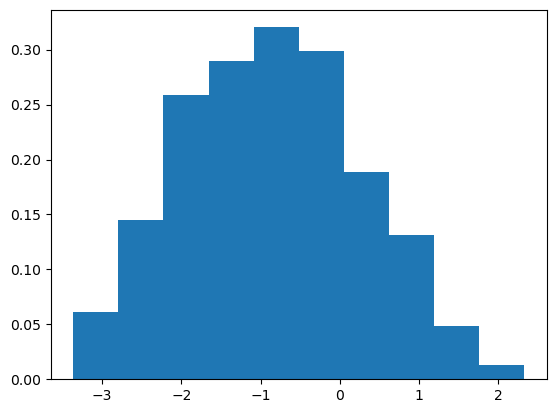

In [50]:
plt.hist(logp_values, density=True)
plt.show()

Get the embeddings and calculate this thing:

In [51]:
path_to_embeddings_npy = 'embeddings.npy'
embeddings = np.load(path_to_embeddings_npy)
mi_1 = mutual_info_regression(embeddings, logp_values)

Calculate the same thing for fingerprints:

In [52]:
mi_2 = mutual_info_regression(fingerprints, logp_values)

Добавь своё сравнение

In [53]:
np.mean(mi_1), np.mean(mi_2)

(1.400467184665673, 0.1926309279026978)

## Experiment 2

In [54]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma, gamma

def estimate_entropy(X, k=5):
    """
    Estimate entropy of a continuous random variable using k-NN method.
    
    Parameters:
    X (np.ndarray): Data matrix of shape (n_samples, n_dimensions)
    k (int): Number of nearest neighbors
    
    Returns:
    float: Estimated entropy in nats
    """
    n_samples = X.shape[0]
    
    # Find k-nearest neighbors
    knn = NearestNeighbors(metric='euclidean', n_neighbors=k+1)
    knn.fit(X)
    distances = knn.kneighbors()[0]
    distances = distances[:, -1]  # Get distance to k-th neighbor
    
    # Calculate entropy using KSG estimator
    d = X.shape[1]  # dimensionality
    volume_unit_ball = np.pi ** (d/2) / gamma(d/2 + 1)
    entropy = (d * np.mean(np.log(distances)) + 
              np.log(volume_unit_ball) + digamma(n_samples) - digamma(k))
    
    return entropy

def estimate_mi(X, Y, k=5):
    """
    Estimate mutual information between two sets of embeddings using k-nearest neighbors.
    
    Parameters:
    X (np.ndarray): First set of embeddings, shape (n_samples, k_dimensions)
    Y (np.ndarray): Second set of embeddings, shape (n_samples, l_dimensions)
    k (int): Number of nearest neighbors to use
    
    Returns:
    float: Estimated mutual information in nats
    """
    n_samples = X.shape[0]
    
    # Assert same number of samples
    if n_samples != Y.shape[0]:
        raise ValueError("X and Y must have same number of samples")
    
    # Find k-nearest neighbors for joint space (X,Y)
    xy = np.hstack([X, Y])
    knn_xy = NearestNeighbors(metric='euclidean', n_neighbors=k+1)
    knn_xy.fit(xy)
    r_xy = knn_xy.kneighbors()[0]
    r_xy = r_xy[:, -1]  # Get distance to k-th neighbor
    
    # Find k-nearest neighbors for X
    knn_x = NearestNeighbors(metric='euclidean', n_neighbors=k+1)
    knn_x.fit(X)
    r_x = knn_x.kneighbors()[0]
    r_x = r_x[:, -1]
    
    # Find k-nearest neighbors for Y
    knn_y = NearestNeighbors(metric='euclidean', n_neighbors=k+1)
    knn_y.fit(Y)
    r_y = knn_y.kneighbors()[0]
    r_y = r_y[:, -1]
    
    # Estimate mutual information
    mi = (digamma(k) + digamma(n_samples) - 
          np.mean(digamma(r_x.size + 1) + digamma(r_y.size + 1)))
    
    return max(0, mi)  # MI should not be negative

def estimate_nmi(X, Y, k=5, normalization='arithmetic'):
    """
    Estimate normalized mutual information between two sets of embeddings.
    
    Parameters:
    X (np.ndarray): First set of embeddings, shape (n_samples, k_dimensions)
    Y (np.ndarray): Second set of embeddings, shape (n_samples, l_dimensions)
    k (int): Number of nearest neighbors
    normalization (str): Type of normalization:
        'arithmetic': 2*MI(X,Y)/(H(X) + H(Y))
        'geometric': MI(X,Y)/sqrt(H(X)*H(Y))
        'min': MI(X,Y)/min(H(X),H(Y))
        'max': MI(X,Y)/max(H(X),H(Y))
    
    Returns:
    tuple: (nmi, mi, h_x, h_y) - normalized MI, raw MI, entropy of X, entropy of Y
    """
    # Calculate mutual information
    mi = estimate_mi(X, Y, k)
    
    # Calculate individual entropies
    h_x = estimate_entropy(X, k)
    h_y = estimate_entropy(Y, k)
    
    # Calculate normalized mutual information based on chosen method
    if normalization == 'arithmetic':
        nmi = 2 * mi / (h_x + h_y)
    elif normalization == 'geometric':
        nmi = mi / np.sqrt(h_x * h_y)
    elif normalization == 'min':
        nmi = mi / min(h_x, h_y)
    elif normalization == 'max':
        nmi = mi / max(h_x, h_y)
    else:
        raise ValueError("Unknown normalization method")
    
    return nmi, mi, h_x, h_y

### Test sample

In [55]:
if __name__ == "__main__":
    # Generate sample embeddings
    np.random.seed(42)
    n_samples = 1000
    k_dim = 64
    l_dim = 128
    
    # Create correlated embeddings for testing
    base = np.random.randn(n_samples, k_dim)
    noise = np.random.randn(n_samples, l_dim) * 0.1
    X = base @ np.random.randn(k_dim, k_dim)  # First embedding
    Y = np.hstack([base, noise])  # Second embedding (partially correlated)
    
    # Calculate normalized mutual information with different normalizations
    for norm in ['arithmetic', 'geometric', 'min', 'max']:
        nmi, mi, h_x, h_y = estimate_nmi(X, Y, k=5, normalization=norm)
        print(f"\nNormalization method: {norm}")
        print(f"NMI: {nmi:.4f}")
        print(f"MI: {mi:.4f} nats")
        print(f"Entropy X: {h_x:.4f} nats")
        print(f"Entropy Y: {h_y:.4f} nats")
    
    # Test with independent embeddings
    X_ind = np.random.randn(n_samples, k_dim)
    Y_ind = np.random.randn(n_samples, l_dim)
    nmi_ind, mi_ind, h_x_ind, h_y_ind = estimate_nmi(X_ind, Y_ind, k=5)
    print("\nIndependent embeddings:")
    print(f"NMI: {nmi_ind:.4f}")
    print(f"MI: {mi_ind:.4f} nats")


Normalization method: arithmetic
NMI: 0.0000
MI: 0.0000 nats
Entropy X: 229.3598 nats
Entropy Y: 197.4027 nats

Normalization method: geometric
NMI: 0.0000
MI: 0.0000 nats
Entropy X: 229.3598 nats
Entropy Y: 197.4027 nats

Normalization method: min
NMI: 0.0000
MI: 0.0000 nats
Entropy X: 229.3598 nats
Entropy Y: 197.4027 nats

Normalization method: max
NMI: 0.0000
MI: 0.0000 nats
Entropy X: 229.3598 nats
Entropy Y: 197.4027 nats

Independent embeddings:
NMI: 0.0000
MI: 0.0000 nats


Вот тут какая-то хуйня про Unit Ball и что для высоких размерностей он вызывает Overflow, поэтому фикс ниже.

In [56]:
# Calculate normalized mutual information with different normalizations
np.random.seed(42)
X = embeddings
Y = fingerprints
for norm in ['arithmetic', 'geometric', 'min', 'max']:
    nmi, mi, h_x, h_y = estimate_nmi(X, Y, k=5, normalization=norm)
    print(f"\nNormalization method: {norm}")
    print(f"NMI: {nmi:.4f}")
    print(f"MI: {mi:.4f} nats")
    print(f"Entropy X: {h_x:.4f} nats")
    print(f"Entropy Y: {h_y:.4f} nats")

OverflowError: (34, 'Numerical result out of range')

С этой штукой какие-то значения есть, но всё равно ошибки. Короче я не уверен, что они нормик. Фикс ниже.

In [ ]:
def estimate_entropy(X, k):
    """
    Estimate the entropy of a dataset using the KSG estimator.
    """
    n_samples, d = X.shape  # Number of samples and dimensionality

    # Find k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X)
    distances, _ = nbrs.kneighbors(X)
    distances = distances[:, -1]  # Get the distance to the k-th neighbor

    # Calculate the volume of the unit ball in high dimensions
    # Use an asymptotic approximation for high-dimensional data
    volume_unit_ball = (2 * np.pi * np.e / d) ** (d / 2)

    # Calculate entropy using KSG estimator
    entropy = (d * np.mean(np.log(distances)) + 
               np.log(volume_unit_ball) + digamma(n_samples) - digamma(k))

    return entropy

def estimate_nmi(X, Y, k, normalization='arithmetic'):
    """
    Estimate normalized mutual information between two datasets.
    """
    # Calculate individual entropies
    h_x = estimate_entropy(X, k)
    h_y = estimate_entropy(Y, k)

    # Calculate joint entropy
    XY = np.hstack((X, Y))
    h_xy = estimate_entropy(XY, k)

    # Calculate mutual information
    mi = h_x + h_y - h_xy

    # Calculate normalized mutual information based on chosen method
    if normalization == 'arithmetic':
        nmi = mi / ((h_x + h_y) / 2)
    elif normalization == 'geometric':
        nmi = mi / np.sqrt(h_x * h_y)
    elif normalization == 'min':
        nmi = mi / min(h_x, h_y)
    elif normalization == 'max':
        nmi = mi / max(h_x, h_y)
    else:
        raise ValueError("Invalid normalization method. Choose from 'arithmetic', 'geometric', 'min', 'max'.")

    return nmi, mi, h_x, h_y

# Example usage
np.random.seed(42)
X = embeddings  # Replace with your embeddings
Y = fingerprints  # Replace with your fingerprints

for norm in ['arithmetic', 'geometric', 'min', 'max']:
    nmi, mi, h_x, h_y = estimate_nmi(X, Y, k=5, normalization=norm)
    print(f"\nNormalization method: {norm}")
    print(f"NMI: {nmi:.4f}")
    print(f"MI: {mi:.4f} nats")
    print(f"Entropy X: {h_x:.4f} nats")
    print(f"Entropy Y: {h_y:.4f} nats")


Normalization method: arithmetic
NMI: nan
MI: nan nats
Entropy X: 117.9666 nats
Entropy Y: -inf nats


/tmp/ipykernel_514110/1855533866.py:17: RuntimeWarning: divide by zero encountered in log
  entropy = (d * np.mean(np.log(distances)) +
/tmp/ipykernel_514110/1855533866.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(volume_unit_ball) + digamma(n_samples) - digamma(k))
/tmp/ipykernel_514110/1855533866.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(volume_unit_ball) + digamma(n_samples) - digamma(k))
/tmp/ipykernel_514110/1855533866.py:35: RuntimeWarning: invalid value encountered in double_scalars
  mi = h_x + h_y - h_xy


Юзаем PCA для фингерпринтов

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.decomposition import PCA

def get_pca_fingerprints(smiles_list, n_components=500):
    """
    Generate PCA-reduced fingerprints for a list of SMILES strings.
    """
    fingerprints = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Generate the full RDKFingerprint
            full_fp = AllChem.RDKFingerprint(mol)
            # Convert the fingerprint to a bit vector
            bit_vector = np.array(full_fp)
            fingerprints.append(bit_vector)
    
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    reduced_fingerprints = pca.fit_transform(fingerprints)
    return reduced_fingerprints

# Example usage
with open('smiles.csv', 'r') as f:
    smiles_list = [line.strip() for line in f]

# Get PCA-reduced fingerprints
pca_fingerprints = get_pca_fingerprints(smiles_list, n_components=128)
print("PCA fingerprints shape:", pca_fingerprints.shape)

PCA fingerprints shape: (400, 128)


Функция вызвалась без ошибок.

In [ ]:
# Example usage
np.random.seed(42)
X = embeddings  # Replace with your embeddings
Y = pca_fingerprints  # Replace with your fingerprints

for norm in ['arithmetic', 'geometric', 'min', 'max']:
    nmi, mi, h_x, h_y = estimate_nmi(X, Y, k=5, normalization=norm)
    print(f"\nNormalization method: {norm}")
    print(f"NMI: {nmi:.4f}")
    print(f"MI: {mi:.4f} nats")
    print(f"Entropy X: {h_x:.4f} nats")
    print(f"Entropy Y: {h_y:.4f} nats")


Normalization method: arithmetic
NMI: -1.6146
MI: -206.2212 nats
Entropy X: 117.9666 nats
Entropy Y: 137.4813 nats

Normalization method: geometric
NMI: -1.6193
MI: -206.2212 nats
Entropy X: 117.9666 nats
Entropy Y: 137.4813 nats

Normalization method: min
NMI: -1.7481
MI: -206.2212 nats
Entropy X: 117.9666 nats
Entropy Y: 137.4813 nats

Normalization method: max
NMI: -1.5000
MI: -206.2212 nats
Entropy X: 117.9666 nats
Entropy Y: 137.4813 nats
